<a href="https://colab.research.google.com/github/cjfergie/Reinforcement-Learning/blob/main/Recession_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import datetime
import numpy as np
import pandas_datareader.data as pdr

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

### Possible leading indicators:



*   yield curve
*   unemployment rate
*   change in real private inventories
*   new private housing permits
*   percent chnage in housing prices
*   percent change in retail sales




In [5]:
start = "1970-01-01"
end = datetime.date.today()

def pct_change_on_last_year(df):
  "compute pct_change on previous year, assuming quarterly"
  return (df - df.shift(4))/df.shift(4)

def get_indicators_from_fred(start=start, end=end):
  """
  Fetch quarterly data on 6 leading indicators from time period start: end
  """
  #yield curve, unemployment, change in inventory, new private housing permits
  df1 = (
      pdr.DataReader(
      ["T10Y2Y", "UNRATE", "CBIC1", "PERMIT"], "fred", start, end)
      .resample("QS")
      .mean()
  )

  # percentage change in hiusing prices and retail sales
  df2 = (
      pdr.DataReader(
      ["USSTHPI", "SLRTTO01USQ661S"], "fred", start, end)
      .resample("QS") #already quarterly, adjusting so index is the same
      .mean()
      .pipe(pct_change_on_last_year)
      .dropna()
  )

  indicators = (
      df1
      .join(df2)
      .dropna()
      .rename(columns=dict(
          USSTHPI="pct_change_hpi",
          T10Y2Y="yield_curve",
          UNRATE="unemp",
          CBIC1="inventory",
          SLRTTO01USQ661S="retail_sales",
          PERMIT="house_permits"
      ))
  )

  return indicators

indicators = get_indicators_from_fred()

In [6]:
indicators.head()

,yield_curve,unemp,inventory,house_permits,pct_change_hpi,retail_sales
DATE,,,,,,
1976-04-01,0.801364,7.566667,58.961,1171.333333,0.076201,0.056936
1976-07-01,1.099687,7.733333,53.269,1345.000000,0.087298,0.037207
1976-10-01,1.467377,7.766667,19.461,1489.000000,0.080039,0.047523
1977-01-01,1.332222,7.500000,33.147,1562.000000,0.105489,0.037939
1977-04-01,1.248254,7.133333,49.461,1693.333333,0.111179,0.032931


In [7]:
indicators.tail()

,yield_curve,unemp,inventory,house_permits,pct_change_hpi,retail_sales
DATE,,,,,,
2017-04-01,0.963333,4.366667,26.048,1265.666667,0.056301,0.022948
2017-07-01,0.878730,4.333333,55.486,1289.000000,0.053762,0.024696
2017-10-01,0.677097,4.166667,42.140,1322.333333,0.054313,0.037249
2018-01-01,0.598033,4.033333,34.055,1341.000000,0.061498,0.024168
2018-04-01,0.443594,3.933333,0.466,1344.666667,0.057334,0.029594


In [8]:
test = (
    pdr.DataReader(
      ["T10Y2Y", "UNRATE", "CBIC1", "PERMIT"], "fred", start, end)
    .resample("QS")
    .mean()
    )
test.tail()

,T10Y2Y,UNRATE,CBIC1,PERMIT
DATE,,,,
2023-04-01,-0.668571,3.566667,14.928,1451.333333
2023-07-01,-0.766984,3.700000,77.764,1485.000000
2023-10-01,-0.360806,3.733333,54.905,1486.000000
2024-01-01,-0.325902,3.800000,NaN,1490.000000
2024-04-01,-0.353333,NaN,NaN,NaN


In [9]:
test = pdr.DataReader(["SLRTTO01USQ661S"], "fred", start, end)
test.tail()

,SLRTTO01USQ661S
DATE,
2017-04-01,103.313300
2017-07-01,103.973982
2017-10-01,105.715425
2018-01-01,105.132537
2018-04-01,106.370794


In [13]:
def get_recession_data():
  recession = (
      pdr.DataReader(["USRECQ"], "fred", start, end)
      .rename(columns=dict(USRECQ="recession"))
      ["recession"]
  )

  # extract start and end date for each recession
  start_dates = recession.loc[recession.diff() > 0].index.tolist()
  if recession.iloc[0] > 0:
    start_dates = [recession.index[0]] + start_dates

  end_dates = recession.loc[recession.diff() < 0].index.tolist()

  n_starts = len(start_dates)
  n_ends = len(end_dates)
  if not (n_starts == n_ends) or (n_starts == n_ends + 1):
    # if the last date is still within a recession then n_starts = n_ends + 1
    raise ValueError("Need to have same number of start/end dates!")

  return recession, start_dates, end_dates

recession, start_dates, end_dates = get_recession_data()

In [14]:
recession.tail()

DATE
2023-01-01    0
2023-04-01    0
2023-07-01    0
2023-10-01    0
2024-01-01    0
Name: recession, dtype: int64

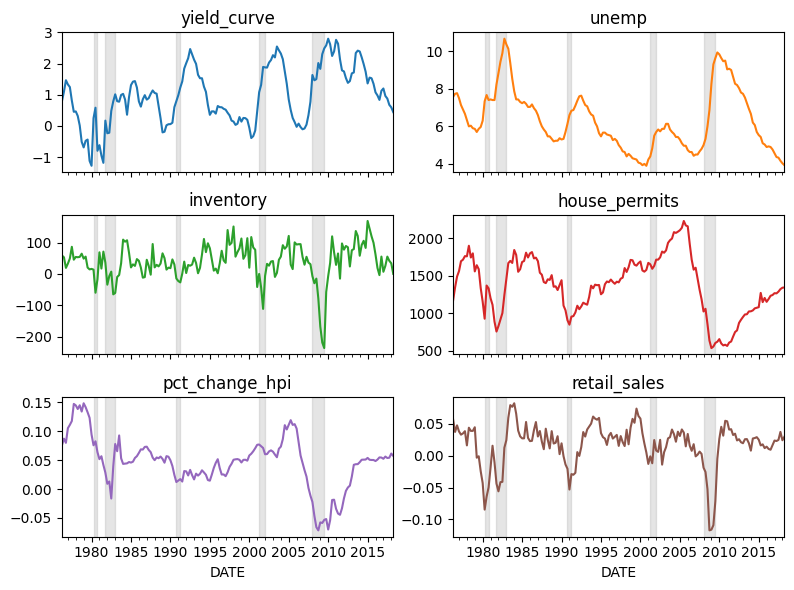

In [19]:
def add_recession_bands(ax):
  for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

axs = indicators.plot(
    subplots=True, figsize=(8, 6), layout=(3, 2), legend=False)

for i, ax in enumerate(axs.flatten()):
  if i < len(indicators.columns):
    add_recession_bands(ax)
    ax.set_title(indicators.columns[i])

fig = axs[0, 0].get_figure()
fig.tight_layout();

In [22]:
def make_inputs_and_targets(indicators, recessions, horizon=1):
  return indicators.join(recessions.shift(horizon)).dropna()

In [23]:
df = make_inputs_and_targets(indicators, recession)

In [24]:
df.head()

,yield_curve,unemp,inventory,house_permits,pct_change_hpi,retail_sales,recession
DATE,,,,,,,
1976-04-01,0.801364,7.566667,58.961,1171.333333,0.076201,0.056936,0.0
1976-07-01,1.099687,7.733333,53.269,1345.000000,0.087298,0.037207,0.0
1976-10-01,1.467377,7.766667,19.461,1489.000000,0.080039,0.047523,0.0
1977-01-01,1.332222,7.500000,33.147,1562.000000,0.105489,0.037939,0.0
1977-04-01,1.248254,7.133333,49.461,1693.333333,0.111179,0.032931,0.0


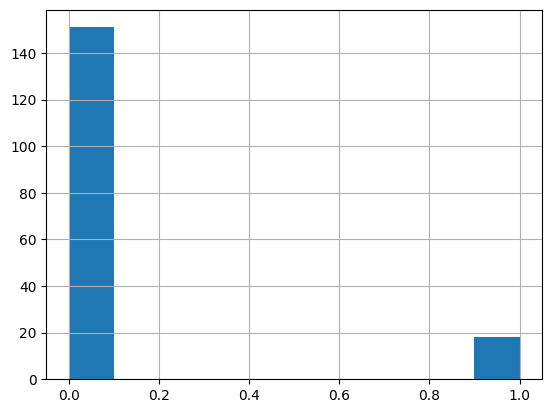

In [25]:
df.recession.hist();

In [26]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [28]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC())
])

In [29]:
accs = []
f1s = []
precisions = []
recalls = []
for i in range(100):
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
  pipe.fit(X_train, y_train)
  acc = pipe.score(X_test, y_test)
  p = pipe.predict(X_test)
  f1 = f1_score(y_test, p)
  prec = precision_score(y_test, p)
  rec = recall_score(y_test, p)
  accs.append(acc)
  f1s.append(f1)
  precisions.append(prec)
  recalls.append(rec)

In [30]:
np.mean(accs), np.mean(f1s), np.mean(precisions), np.mean(recalls)

(0.9618604651162791,
 0.8345541125541125,
 0.8523174603174601,
 0.8420000000000001)